In [2]:
import bitfinex
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import datetime
import time
import os
import zipfile
import seaborn as sns
from pykalman import KalmanFilter
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint
from itertools import combinations
import statsmodels.api as sm
plt.style.use('seaborn-whitegrid')

## Collecting data ##

In [3]:
def fetch_data(start=1364767200000, stop=1545346740000, symbol='btcusd', interval='1m', tick_limit=1000, step=60000000):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()

    data = []
    start = start - step
    while start < stop:

        start = start + step
        end = start + step
        res = api_v2.candles(symbol=symbol, interval=interval, limit=tick_limit, start=start, end=end)
        data.extend(res)
        print('Retrieving data from {} to {} for {}'.format(pd.to_datetime(start, unit='ms'),
                                                            pd.to_datetime(end, unit='ms'), symbol))
        time.sleep(1.5)
    return data

def fetch_all_data(assetList,resolution):
    dfs=[]
    for coin in assetList:
        bin_size = resolution # This is the resolution at which we request the data
        limit = 1000 # How many data points per call are we asking for
        time_step = 1000 * 60 * limit # From the above calulate the size of each sub querry
        # Fill in the start and end time of interest and convert it to timestamps
        t_start = datetime.datetime(2022, 1, 1, 0, 0)
        t_start = time.mktime(t_start.timetuple()) * 1000
        print(t_start)

        t_stop = datetime.datetime(2022, 11, 24, 23, 59)
        t_stop = time.mktime(t_stop.timetuple()) * 1000

        # Create an bitfinex_api instance
        api_v1 = bitfinex.bitfinex_v1.api_v1()
        pair_data = fetch_data(start=t_start, stop=t_stop, symbol=coin, interval=bin_size, tick_limit=limit, step=time_step)
        ind = [np.ndim(x) != 0 for x in pair_data]
        pair_data = [i for (i, v) in zip(pair_data, ind) if v]

        # Create pandas data frame and clean data
        names = ['time', 'open', 'close', 'high', 'low', 'volume']
        df = pd.DataFrame(pair_data, columns=names)
        df.drop_duplicates(inplace=True)
        df.set_index('time', inplace=True)
        df.sort_index(inplace=True)
        df.index = pd.to_datetime(df.index, unit='ms')
        df.to_csv(f'1yr_{coin}.csv')
        dfs.append(df)
    return dfs

In [4]:
#dfs = fetch_all_data(["BTCUSD","ETHUSD","LTCUSD","NEOUSD","XMRUSD","XRPUSD","ZECUSD","SOLUSD"],"1m")

In [5]:
eth = pd.read_csv("1yr_ETHUSD.csv", parse_dates = ["time"])
btc = pd.read_csv("1yr_BTCUSD.csv",parse_dates = ["time"])
ltc = pd.read_csv("1yr_LTCUSD.csv",parse_dates = ["time"])
neo = pd.read_csv("1yr_NEOUSD.csv",parse_dates = ["time"])
xmr = pd.read_csv("1yr_XMRUSD.csv",parse_dates = ["time"])
xrp = pd.read_csv("1yr_XRPUSD.csv",parse_dates = ["time"])
zec = pd.read_csv("1yr_ZECUSD.csv",parse_dates = ["time"])
sol = pd.read_csv("1yr_SOLUSD.csv",parse_dates = ["time"])

btc_prices = btc[["time","close"]].rename(columns = {"close": "btc_price"})

all_prices = btc_prices.merge(eth[["time","close"]].rename(columns = {"close": "eth_price"}), on = "time", how = "left")
all_prices = all_prices.merge(ltc[["time","close"]].rename(columns = {"close": "ltc_price"}), on = "time", how = "left")
all_prices = all_prices.merge(neo[["time","close"]].rename(columns = {"close": "neo_price"}), on = "time", how = "left")
all_prices = all_prices.merge(xmr[["time","close"]].rename(columns = {"close": "xmr_price"}), on = "time", how = "left")
all_prices = all_prices.merge(xrp[["time","close"]].rename(columns = {"close": "xrp_price"}), on = "time", how = "left")
all_prices = all_prices.merge(zec[["time","close"]].rename(columns = {"close": "zec_price"}), on = "time", how = "left")
all_prices = all_prices.merge(sol[["time","close"]].rename(columns = {"close": "sol_price"}), on = "time", how = "left")
all_prices = all_prices.set_index("time")
all_prices["eth_price"] = all_prices["eth_price"].interpolate()
all_prices["ltc_price"] = all_prices["ltc_price"].interpolate()
all_prices["neo_price"] = all_prices["neo_price"].interpolate()
all_prices["xmr_price"] = all_prices["xmr_price"].interpolate()
all_prices["xrp_price"] = all_prices["xrp_price"].interpolate()
all_prices["zec_price"] = all_prices["zec_price"].interpolate()
all_prices["sol_price"] = all_prices["sol_price"].interpolate()
all_prices.to_csv("all_prices.csv")

all_prices["btc_price"] = np.log(all_prices["btc_price"])
all_prices["eth_price"] = np.log(all_prices["eth_price"])
all_prices["ltc_price"] = np.log(all_prices["ltc_price"])
all_prices["neo_price"] = np.log(all_prices["neo_price"])
all_prices["xmr_price"] = np.log(all_prices["xmr_price"])
all_prices["xrp_price"] = np.log(all_prices["xrp_price"])
all_prices["zec_price"] = np.log(all_prices["zec_price"])
all_prices["sol_price"] = np.log(all_prices["sol_price"])
all_prices

,btc_price,eth_price,ltc_price,neo_price,xmr_price,xrp_price,zec_price,sol_price
time,,,,,,,,
2022-01-01 08:00:00,10.762219,8.220269,4.997888,3.267628,5.497045,-0.173247,NaN,NaN
2022-01-01 08:01:00,10.761259,8.218976,4.995522,3.267409,5.496102,-0.174008,4.997077,5.153003
2022-01-01 08:02:00,10.761344,8.219030,4.996536,3.267190,5.495815,-0.174056,4.997955,5.152598
2022-01-01 08:03:00,10.761198,8.219326,4.996874,3.266971,5.495667,-0.174103,4.998270,5.153754
2022-01-01 08:04:00,10.761492,8.219919,4.996807,3.266751,5.495519,-0.174151,4.998585,5.154909
...,...,...,...,...,...,...,...,...
2022-11-26 10:51:00,9.718001,7.108244,4.354424,1.950030,4.927181,-0.897165,3.744704,2.702502
2022-11-26 10:52:00,9.718061,7.108408,4.355221,1.950016,4.927181,-0.896866,3.744622,2.701160
2022-11-26 10:53:00,9.718061,7.108244,4.355118,1.950002,4.927181,-0.896567,3.744559,2.698404


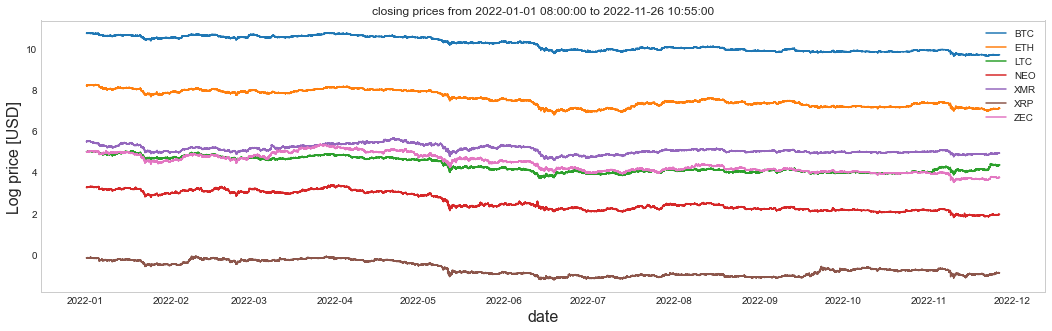

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
ax.plot(all_prices["btc_price"], label = "BTC")
ax.plot(all_prices["eth_price"], label = "ETH")
ax.plot(all_prices["ltc_price"], label = "LTC")
ax.plot(all_prices["neo_price"], label = "NEO")
ax.plot(all_prices["xmr_price"], label = "XMR")
ax.plot(all_prices["xrp_price"], label = "XRP")
ax.plot(all_prices["zec_price"], label = "ZEC")
ax.legend(loc="upper right")
ax.set_xlabel('date', fontsize=16)
ax.set_ylabel('Log price [USD]', fontsize=16)
ax.set_title('closing prices from {} to {}'.format(all_prices.index[0], all_prices.index[-1]))
ax.grid()

plt.show()

## Find Cointegrated Pairs ##

In [7]:
SIZE = 4000
# Read in the data file 
df = pd.read_csv("all_prices.csv", parse_dates = ["time"])
start_date = '2022-01-01'  # extract the date from filename here
end_date = '2022-12-01'

# Get every row from the start date to the end data in 15 minute intervals
df = df[(df['time'] > start_date) & (df['time'] < end_date)]
df = df[df['time'].dt.minute % 15 == 0]
df.head()

,time,btc_price,eth_price,ltc_price,neo_price,xmr_price,xrp_price,zec_price,sol_price
0,2022-01-01 08:00:00,47203.308183,3715.50000,148.10,26.249000,243.970000,0.84093,NaN,NaN
15,2022-01-01 08:15:00,47238.158052,3719.90000,148.57,26.257250,243.710000,0.84240,148.526667,173.07
30,2022-01-01 08:30:00,47275.000000,3722.30000,148.51,26.249000,243.275000,0.84149,148.270000,173.18
44,2022-01-01 08:45:00,47248.000000,3726.41216,148.24,26.247750,244.823333,0.84170,148.448750,172.97
59,2022-01-01 09:00:00,47160.000000,3724.80000,148.12,26.219625,244.387500,0.83961,147.772000,172.85


In [8]:
df = df.iloc[1:]
prices_df = df.drop("time", axis = 1)
prices_df.dropna(axis = 1, inplace = True)
prices_df.head()

,btc_price,eth_price,ltc_price,neo_price,xmr_price,xrp_price,zec_price,sol_price
15,47238.158052,3719.90000,148.570000,26.257250,243.710000,0.84240,148.526667,173.070
30,47275.000000,3722.30000,148.510000,26.249000,243.275000,0.84149,148.270000,173.180
44,47248.000000,3726.41216,148.240000,26.247750,244.823333,0.84170,148.448750,172.970
59,47160.000000,3724.80000,148.120000,26.219625,244.387500,0.83961,147.772000,172.850
72,47204.000000,3728.60000,148.356667,26.284111,242.440000,0.84365,147.932500,173.034


In [9]:
def engle_granger(ticker1, ticker2, threshold):
    """Returns (p-value, true) if we reject the null hypothesis and therefore there is cointegration"""
    test_result = coint(prices_df[ticker1], prices_df[ticker2])
    return (test_result[1], test_result[1] <= threshold)

In [16]:
cointegrated_pairs = []
for u, v in combinations(prices_df.columns, 2):
        print(f"Testing {u} and {v}")
        if u != v:
            if (engle_granger(u, v, 0.2)[1]):
                print(f"Found cointegrated pair: {u} and {v}, p-value = {engle_granger(u, v, 0.05)[0]}")
                cointegrated_pairs.append((u, v))

Testing btc_price and eth_price
Testing btc_price and ltc_price
Testing btc_price and neo_price
Found cointegrated pair: btc_price and neo_price, p-value = 0.05373035505362448
Testing btc_price and xmr_price
Testing btc_price and xrp_price
Testing btc_price and zec_price
Testing btc_price and sol_price
Found cointegrated pair: btc_price and sol_price, p-value = 0.11117266510515444
Testing eth_price and ltc_price
Testing eth_price and neo_price
Found cointegrated pair: eth_price and neo_price, p-value = 0.07723541549908938
Testing eth_price and xmr_price
Testing eth_price and xrp_price
Testing eth_price and zec_price
Found cointegrated pair: eth_price and zec_price, p-value = 0.13631668179084627
Testing eth_price and sol_price
Found cointegrated pair: eth_price and sol_price, p-value = 0.19804921427141803
Testing ltc_price and neo_price
Testing ltc_price and xmr_price
Testing ltc_price and xrp_price
Testing ltc_price and zec_price
Testing ltc_price and sol_price
Testing neo_price and xm

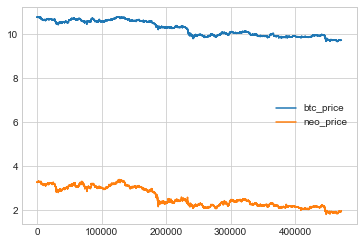

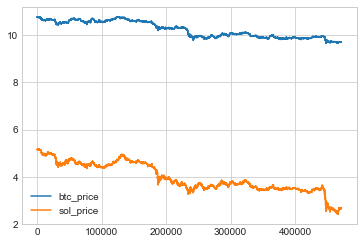

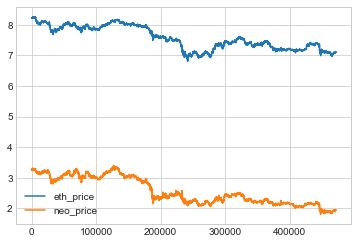

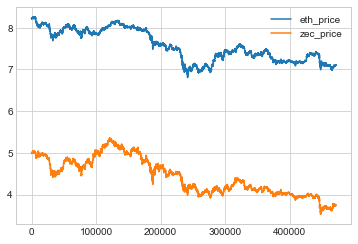

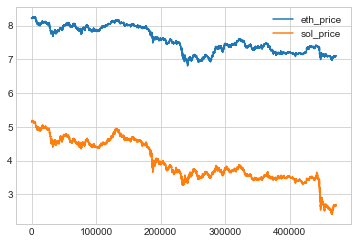

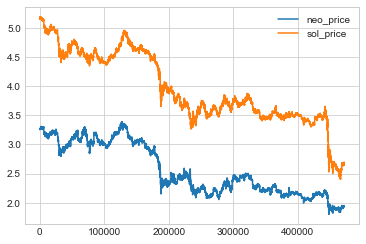

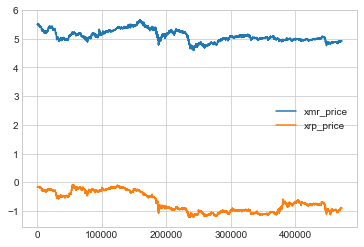

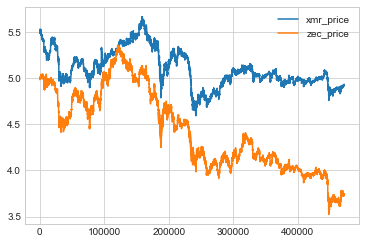

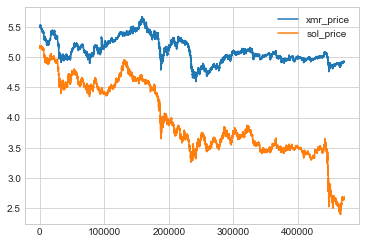

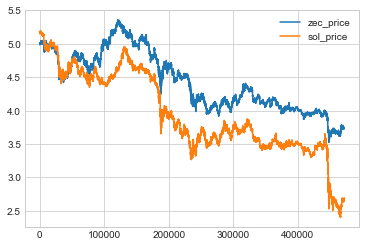

In [17]:
# Plot the cointegrated pairs
for pair in cointegrated_pairs:
    plt.figure(figsize = (6, 4))
    plt.plot(np.log(prices_df[pair[0]]), label = pair[0])
    plt.plot(np.log(prices_df[pair[1]]), label = pair[1])
    plt.legend()
    plt.show()
plt.show()

## Using OLS for Fixed Hedge Ratio ##

In [10]:
lm = LinearRegression()
lm.fit(np.exp(np.array(all_prices["btc_price"].iloc[-43800:])).reshape(-1,1),np.exp(np.array(all_prices["neo_price"].iloc[-43800:])))
alpha = lm.intercept_
beta = lm.coef_
y_pred = alpha + beta[0] * np.exp(all_prices["btc_price"].iloc[-43800:])
print(f"beta (slope) = {beta}, alpha (intercept) = {alpha}")

beta (slope) = [0.0004801], alpha (intercept) = -1.2881204967245559


C:\Users\lygc7\AppData\Local\Temp\ipykernel_5788\3077396358.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(sc)
C:\Users\lygc7\AppData\Local\Temp\ipykernel_5788\3077396358.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(p) for p in all_prices["btc_price"].iloc[-43800:].index])


Text(0, 0.5, 'neo')

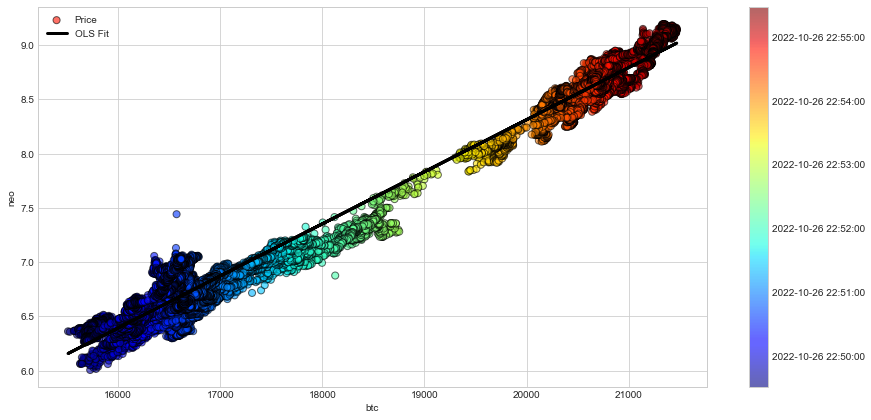

In [11]:
#plot the last month of log price data of xrp vs xmr
x = list(np.exp(all_prices["btc_price"].iloc[-43800:]))
plt.figure(figsize =(15,7))
cm = plt.get_cmap('jet')
sc = plt.scatter(np.exp(all_prices["btc_price"].iloc[-43800:]), np.exp(all_prices["neo_price"].iloc[-43800:]), s=50, c=x, cmap=cm, marker='o',
                alpha=0.6,label='Price',edgecolor='k')
plt.plot(x, y_pred, '-',c='black',linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p) for p in all_prices["btc_price"].iloc[-43800:].index])
plt.xlabel("btc")
plt.ylabel("neo")

Text(0, 0.5, 'spread')

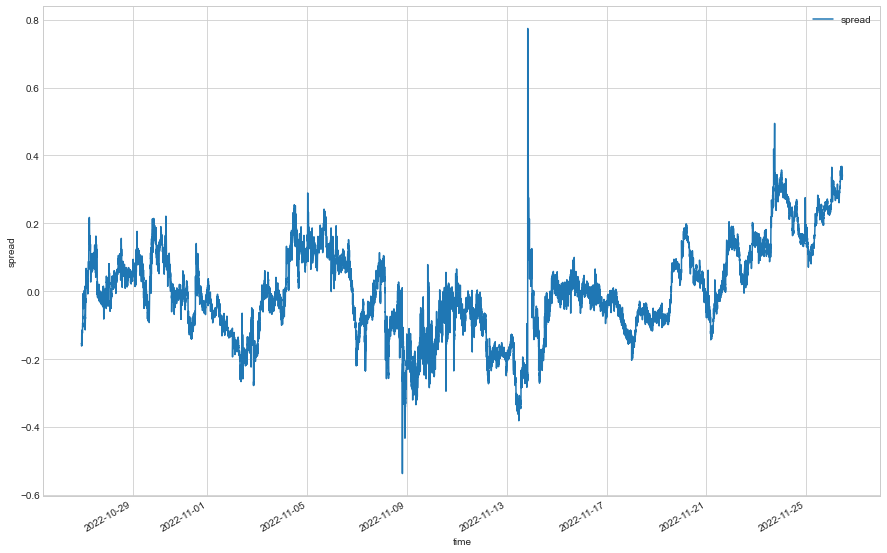

In [40]:
df = pd.DataFrame(np.exp(all_prices["neo_price"].iloc[-43800:]) - np.exp(all_prices["btc_price"].iloc[-43800:])*beta-alpha,
                    index= all_prices["btc_price"].iloc[-43800:].index)
df.columns = ['spread']
df.plot(figsize =(15,10))
plt.ylabel('spread')

mean of spread: -2.3126706029671205e-15


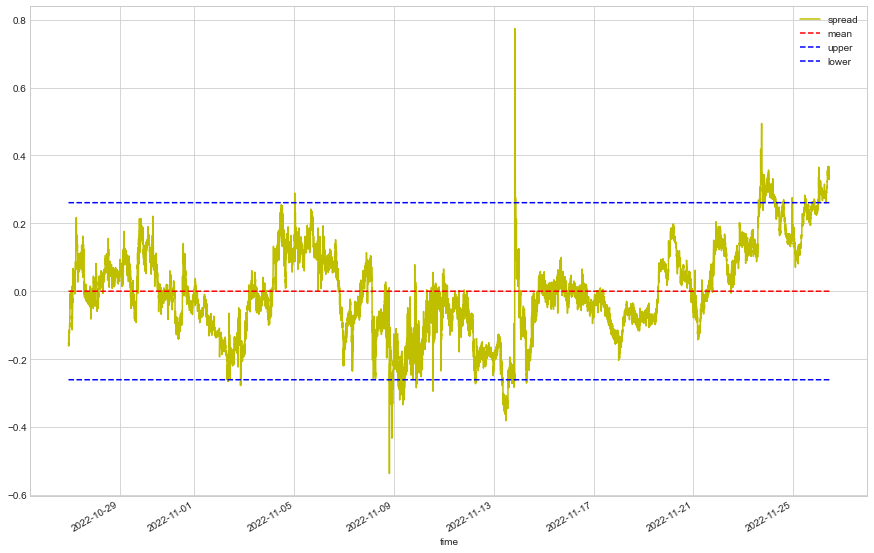

In [41]:
mean = df['spread'].mean()
df['mean'] = df['spread'].mean()
df['upper'] = df['mean'] + 1.96*df['spread'].std()
df['lower'] = df['mean'] - 1.96*df['spread'].std()
df.plot(figsize =(15,10),style=['y', '--r', '--b', '--b'])
print(f"mean of spread: {mean}")

In [44]:
def plot_spread(xticker, yticker, days):
    """plots the spread of XTICKER and YTICKER over DAYS days"""
    lm = LinearRegression()
    minutes = days*24*60
    lm.fit(np.exp(np.array(all_prices[xticker].iloc[-minutes:])).reshape(-1,1),np.exp(np.array(all_prices[yticker].iloc[-minutes:])))
    alpha = lm.intercept_
    beta = lm.coef_
    temp_df = pd.DataFrame(np.exp(all_prices[yticker].iloc[-minutes:]) - np.exp(all_prices[xticker].iloc[-minutes:])*beta-alpha,
                    index= all_prices[xticker].iloc[-minutes:].index)
    temp_df.columns = ['spread']
    temp_df['mean'] = temp_df['spread'].mean()
    temp_df['upper'] = temp_df['mean'] + 1.96*temp_df['spread'].std()
    temp_df['lower'] = temp_df['mean'] - 1.96*temp_df['spread'].std()
    temp_df.plot(figsize =(6,4),style=['g', '--r', '--b', '--b'], title = f"x = {xticker} y = {yticker}")

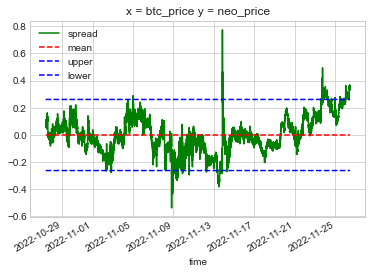

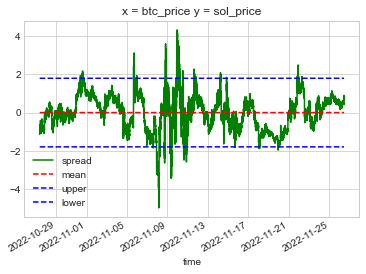

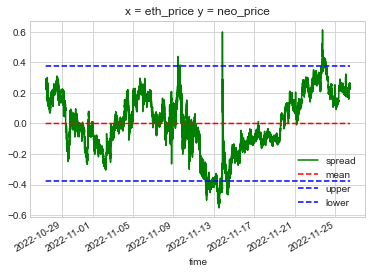

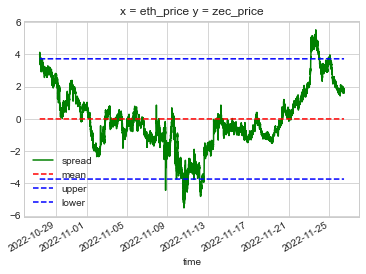

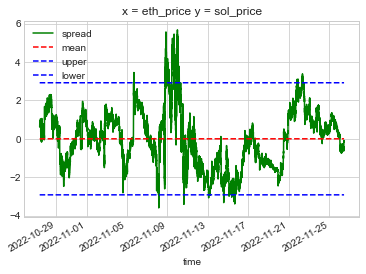

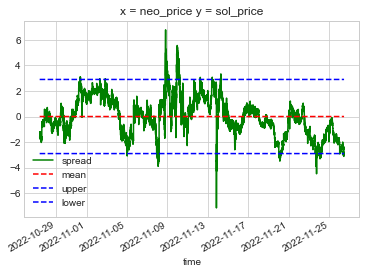

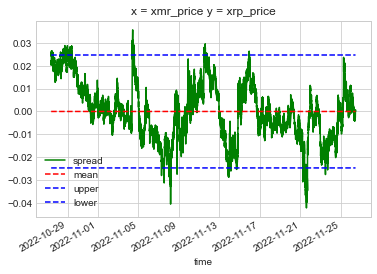

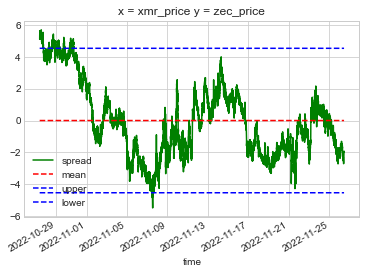

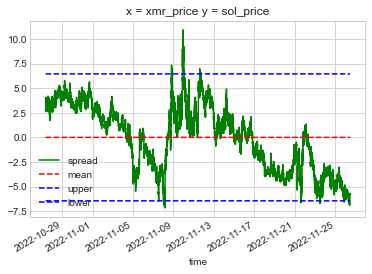

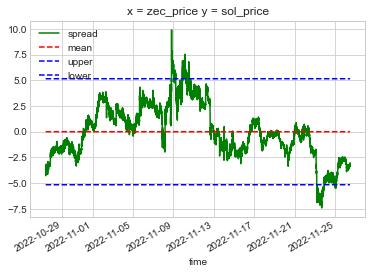

In [45]:
for pair in cointegrated_pairs:
    plot_spread(pair[0],pair[1],30)

## Using Kalman Filtering instead for calculating a more stationary spread ##

Text(0, 0.5, 'intercept')

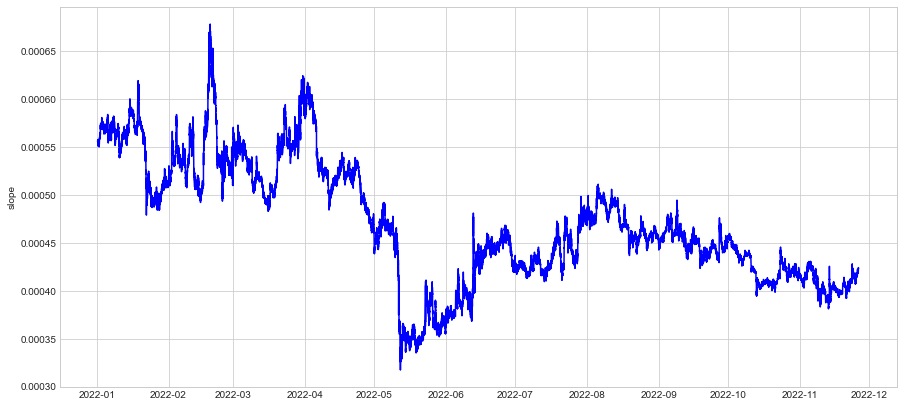

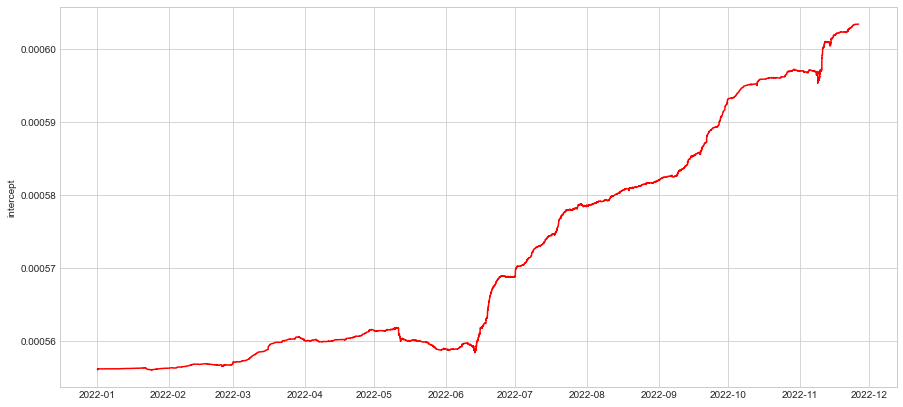

In [74]:
obs_mat = sm.add_constant(np.exp(all_prices["btc_price"].values), prepend=False)[:, np.newaxis]
trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=0.5,
                  transition_covariance=1e-10 * np.eye(2))
state_means, state_covs = kf.filter(np.exp(all_prices["neo_price"].values))
slope=state_means[:, 0] 
intercept=state_means[:, 1]
plt.figure(figsize =(15,7))
plt.plot(all_prices["neo_price"].index, slope, c='b')
plt.ylabel('slope')
plt.figure(figsize =(15,7))
plt.plot(all_prices["neo_price"].index,intercept,c='r')
plt.ylabel('intercept')

Text(0, 0.5, 'kl_spread')

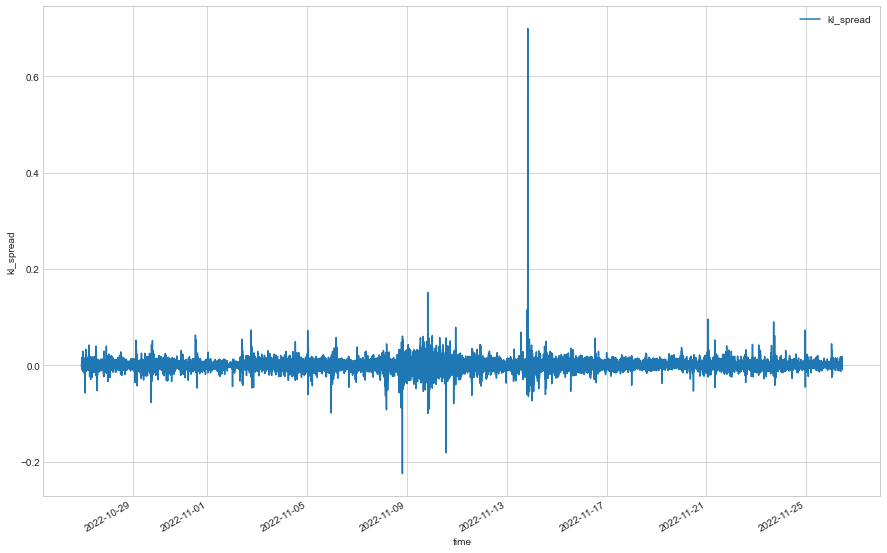

In [75]:
kl_spread = np.exp(all_prices["neo_price"].iloc[-43800:]) - np.exp(all_prices["btc_price"].iloc[-43800:]) * state_means[:,0][-43800:] - state_means[:,1][-43800:]
new_df = pd.DataFrame(kl_spread)
new_df.columns = ['kl_spread']
new_df.plot(figsize =(15,10))
plt.ylabel('kl_spread')

mean of spread: 2.0250520136451265e-05


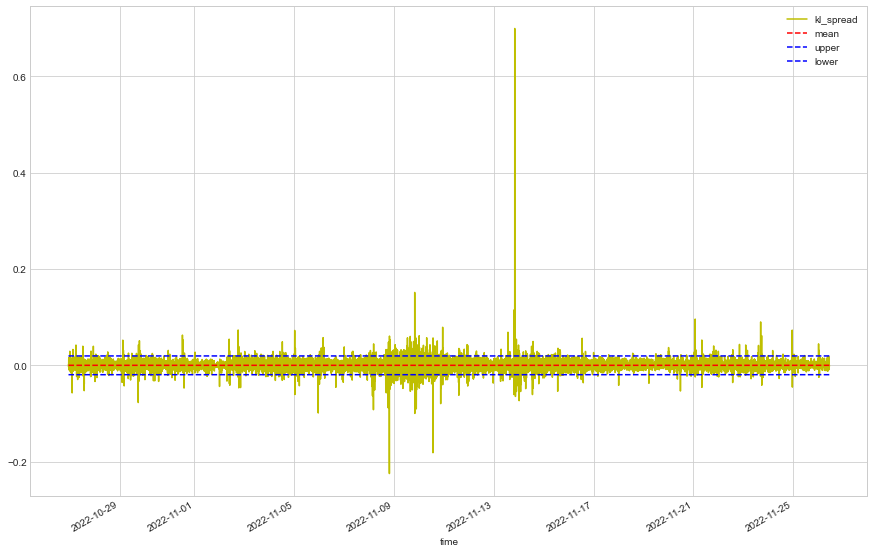

In [76]:
mean = new_df['kl_spread'].mean()
new_df['mean'] = new_df['kl_spread'].mean()
new_df['upper'] = new_df['mean'] + 2*new_df['kl_spread'].std()
new_df['lower'] = new_df['mean'] - 2*new_df['kl_spread'].std()
new_df.plot(figsize =(15,10),style=['y', '--r', '--b', '--b'])
print(f"mean of spread: {mean}")

## Comparing the pnl of OLS Static Hedge Ratio vs. Kalman Filtered Hedge Ratio ##

<AxesSubplot:xlabel='time'>

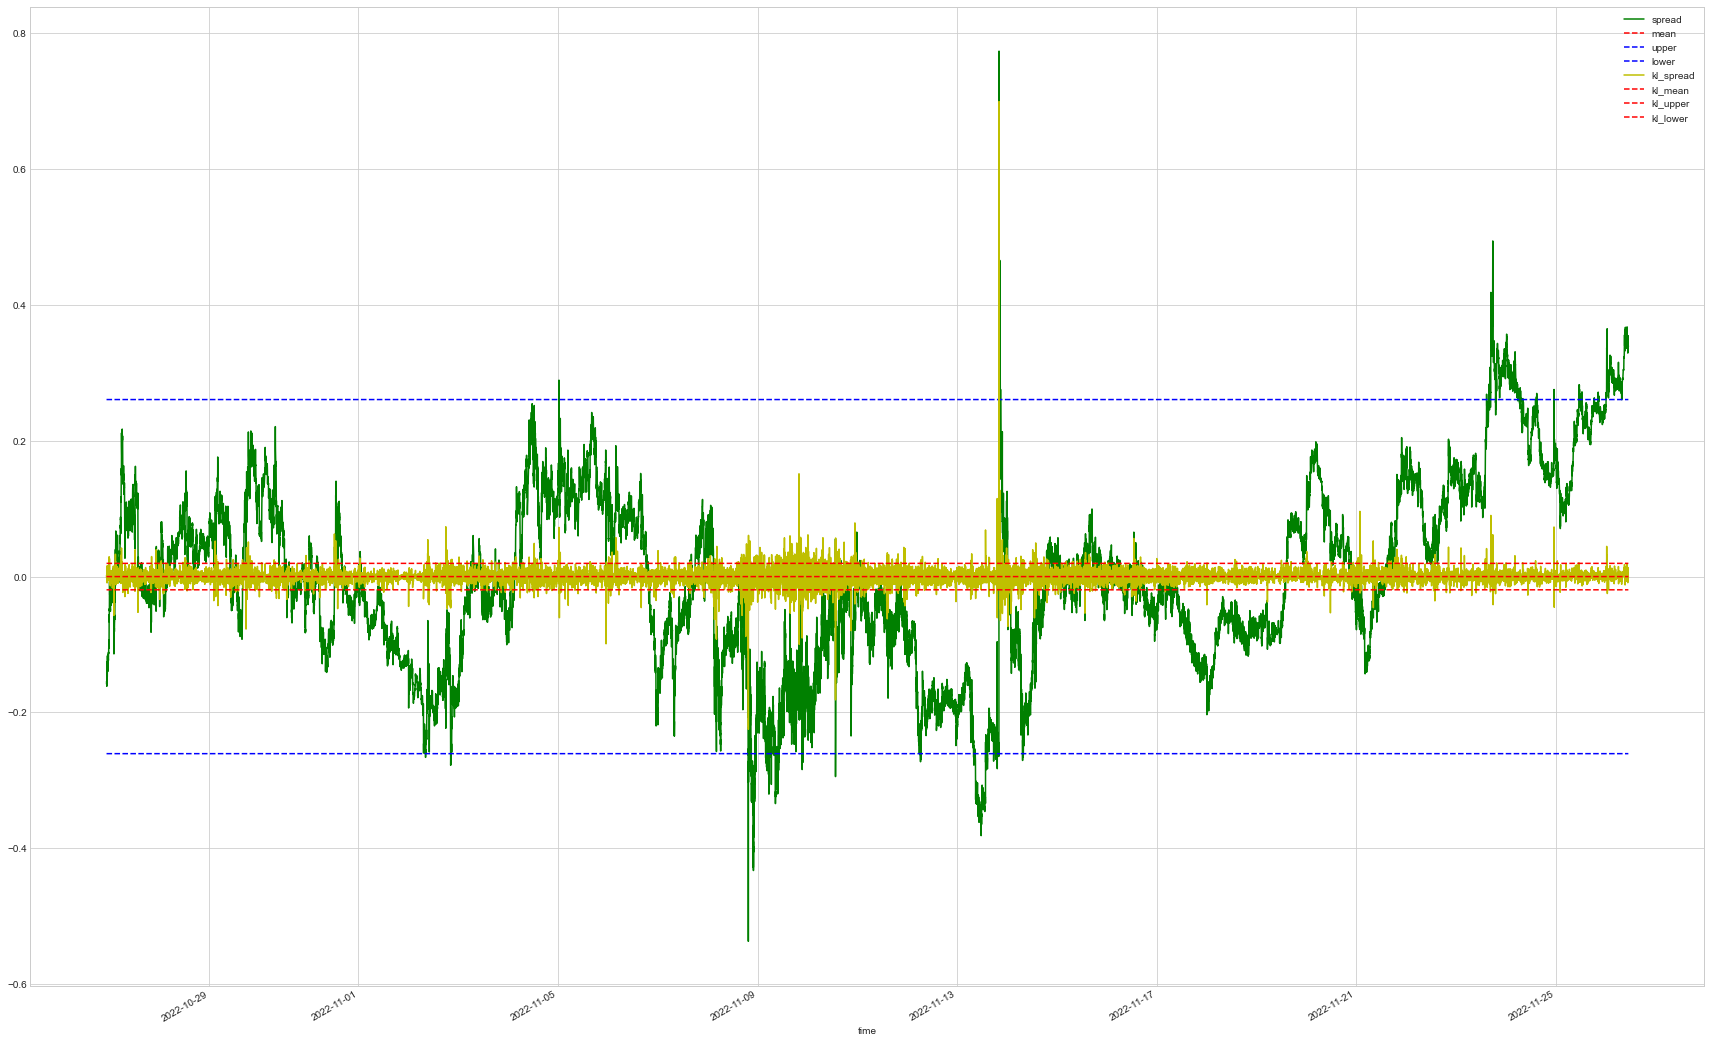

In [77]:
df["kl_spread"]= new_df['kl_spread']
df['kl_mean'] = new_df['kl_spread'].mean()
df['kl_upper'] = new_df['mean'] + 2*new_df['kl_spread'].std()
df['kl_lower'] = new_df['mean'] - 2*new_df['kl_spread'].std()
df.plot(figsize =(30,20),style=['g', '--r', '--b', '--b','y', '--r', '--r', '--r'])

In [78]:
# check if which spread is more stationary 
adf = sm.tsa.stattools.adfuller(df['spread'], maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.10f' % adf[1])

ADF test statistic: -6.79
	1%: -3.430
	5%: -2.862
	10%: -2.567
p-value: 0.0000000023


In [86]:
adf = sm.tsa.stattools.adfuller(df['kl_spread'], maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.10f' % adf[1])

ADF test statistic: -84.02
	1%: -3.430
	5%: -2.862
	10%: -2.567
p-value: 0.0000000000


In [100]:
df["kl_slope"] = slope[-43800:]
df["kl_intercept"] = intercept[-43800:]
df

,spread,mean,upper,lower,kl_spread,kl_mean,kl_upper,kl_lower,kl_slope,kl_intercept
time,,,,,,,,,,
2022-10-26 22:49:00,-0.154092,-2.312671e-15,0.260746,-0.260746,0.002122,0.00002,0.019495,-0.019454,0.000411,0.000597
2022-10-26 22:50:00,-0.154352,-2.312671e-15,0.260746,-0.260746,0.001234,0.00002,0.019495,-0.019454,0.000411,0.000597
2022-10-26 22:51:00,-0.158453,-2.312671e-15,0.260746,-0.260746,-0.001879,0.00002,0.019495,-0.019454,0.000411,0.000597
2022-10-26 22:52:00,-0.156312,-2.312671e-15,0.260746,-0.260746,-0.000220,0.00002,0.019495,-0.019454,0.000411,0.000597
2022-10-26 22:53:00,-0.155332,-2.312671e-15,0.260746,-0.260746,0.000515,0.00002,0.019495,-0.019454,0.000411,0.000597
...,...,...,...,...,...,...,...,...,...,...
2022-11-26 10:51:00,0.340692,-2.312671e-15,0.260746,-0.260746,-0.001679,0.00002,0.019495,-0.019454,0.000423,0.000603
2022-11-26 10:52:00,0.340112,-2.312671e-15,0.260746,-0.260746,-0.001742,0.00002,0.019495,-0.019454,0.000423,0.000603
2022-11-26 10:53:00,0.340012,-2.312671e-15,0.260746,-0.260746,-0.001457,0.00002,0.019495,-0.019454,0.000423,0.000603


In [96]:
df[(df['spread'] > df["upper"].iloc[0]) | (df['spread'] < df["lower"].iloc[0])].index

DatetimeIndex(['2022-11-02 08:17:00', '2022-11-02 08:18:00',
               '2022-11-02 08:19:00', '2022-11-02 20:21:00',
               '2022-11-02 20:22:00', '2022-11-02 20:23:00',
               '2022-11-02 20:25:00', '2022-11-02 20:26:00',
               '2022-11-02 20:27:00', '2022-11-02 20:28:00',
               ...
               '2022-11-26 10:46:00', '2022-11-26 10:47:00',
               '2022-11-26 10:48:00', '2022-11-26 10:49:00',
               '2022-11-26 10:50:00', '2022-11-26 10:51:00',
               '2022-11-26 10:52:00', '2022-11-26 10:53:00',
               '2022-11-26 10:54:00', '2022-11-26 10:55:00'],
              dtype='datetime64[ns]', name='time', length=2345, freq=None)

In [101]:
btc_price_data = pd.read_csv("1yr_BTCUSD.csv", parse_dates = ["time"])

In [102]:
btc_price_data

,time,open,close,high,low,volume
0,2022-01-01 08:00:00,47217.000000,47203.308183,47236.000000,47203.308183,0.267988
1,2022-01-01 08:01:00,47203.000000,47158.000000,47203.000000,47149.182156,3.229932
2,2022-01-01 08:02:00,47147.000000,47162.000000,47173.000000,47140.000000,1.582735
3,2022-01-01 08:03:00,47160.000000,47155.146436,47169.929326,47154.000000,0.051554
4,2022-01-01 08:04:00,47155.146436,47169.000000,47177.889344,47154.594758,0.047191
...,...,...,...,...,...,...
471833,2022-11-26 10:51:00,16612.000000,16614.000000,16614.000000,16612.000000,0.003146
471834,2022-11-26 10:52:00,16614.000000,16615.000000,16615.000000,16614.000000,0.014111
471835,2022-11-26 10:53:00,16615.000000,16615.000000,16615.000000,16615.000000,0.000337
471836,2022-11-26 10:54:00,16615.000000,16616.000000,16616.000000,16615.000000,0.007563


In [95]:
df[(df['kl_spread'] > df["kl_upper"].iloc[0]) | (df['kl_spread'] < df["kl_lower"].iloc[0])].index

DatetimeIndex(['2022-10-27 00:03:00', '2022-10-27 00:04:00',
               '2022-10-27 00:07:00', '2022-10-27 00:13:00',
               '2022-10-27 00:14:00', '2022-10-27 00:15:00',
               '2022-10-27 02:18:00', '2022-10-27 02:19:00',
               '2022-10-27 02:20:00', '2022-10-27 02:21:00',
               ...
               '2022-11-25 11:09:00', '2022-11-26 00:28:00',
               '2022-11-26 00:29:00', '2022-11-26 00:30:00',
               '2022-11-26 00:31:00', '2022-11-26 00:32:00',
               '2022-11-26 00:42:00', '2022-11-26 00:43:00',
               '2022-11-26 00:48:00', '2022-11-26 01:21:00'],
              dtype='datetime64[ns]', name='time', length=1614, freq=None)